# Feature Selection
## Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

below code is trying to combine preprocessed basic features and engineered features

In [13]:
# copy the code from Feature Engineering
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

df = pd.read_csv('Data/cleaned.csv')

# create booking_date
temp = df.rename(columns={
    'arrival_year': 'year',
    'arrival_month': 'month',
    'arrival_date': 'day'
})

df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
df['booking_date'] = df['booking_date'] - pd.Series(
    [pd.Timedelta(i, 'd') for i in df.lead_time],
    index=df.index
)

# split based on booking_date
train = df[df['booking_date']<'2018-07-01'].reset_index(drop=True)
test = df[df['booking_date']>='2018-07-01'].reset_index(drop=True)

# this function will be used to create arrival date related features
def process_arrival_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['arrival_week'] = df['date'].dt.isocalendar().week.astype(float)
    df['arrival_dayofweek'] = df['date'].dt.dayofweek
    df['arrival_quarter'] = df['date'].dt.quarter
    df['arrival_dayofyear'] = df['date'].dt.dayofyear
    df['arrival_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)
    
    df.drop(columns='date', inplace=True)
    

# this function will be used to create booking date related features
def process_booking_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['booking_date'] = df['booking_date'] - pd.Series(
        [pd.Timedelta(i, 'd') for i in df.lead_time],
        index=df.index
    )
    
    df['booking_year'] = df['booking_date'].dt.year
    df['booking_month'] = df['booking_date'].dt.month
    df['booking_week'] = df['booking_date'].dt.isocalendar().week.astype(float)
    df['booking_dayofweek'] = df['booking_date'].dt.dayofweek
    df['booking_quarter'] = df['booking_date'].dt.quarter
    df['booking_dayofyear'] = df['booking_date'].dt.dayofyear
    df['booking_date'] = df['booking_date'].dt.day
    df['booking_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)
    

# call the helper functions
process_arrival_date(train)
process_arrival_date(test)
process_booking_date(train)
process_booking_date(test)

In [14]:
train.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'booking_date', 'arrival_week', 'arrival_dayofweek', 'arrival_quarter',
       'arrival_dayofyear', 'arrival_isweekend', 'booking_year',
       'booking_month', 'booking_week', 'booking_dayofweek', 'booking_quarter',
       'booking_dayofyear', 'booking_isweekend'],
      dtype='object')

In [17]:
# add engineered features to basic features
features_to_be_added = ['booking_date', 'arrival_week', 'arrival_dayofweek', 'arrival_quarter',
       'arrival_dayofyear', 'arrival_isweekend', 'booking_year',
       'booking_month', 'booking_week', 'booking_dayofweek', 'booking_quarter',
       'booking_dayofyear', 'booking_isweekend']

In [3]:
X_train = pd.read_csv('Data/x_train.csv')
y_train = pd.read_csv('Data/y_train.csv')
X_test = pd.read_csv('Data/x_test.csv')
y_test = pd.read_csv('Data/y_test.csv')

In [18]:
X_train[features_to_be_added] = train[features_to_be_added]

## Mutual Information

Mutual information quantifies the amount of information shared between two random variables. Mutual information measures the dependence between a feature and the target variable, indicating how much information about the target is contained in the feature. 

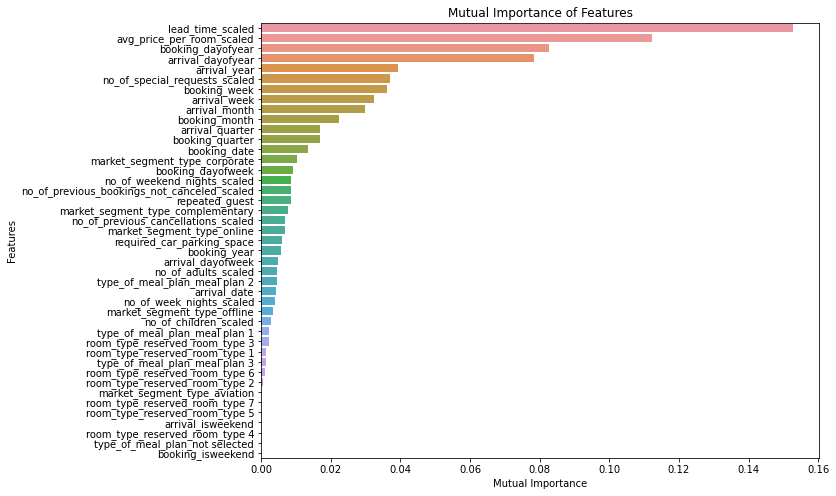

In [25]:
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

# Reshape y to 1-dimensional array
y_train_reshaped = y_train.values.ravel()

# Calculate feature importances using mutual information
importances = mutual_info_classif(X_train, y_train_reshaped)

# Create a pandas Series to hold feature importances
importances_series = pd.Series(importances, index=X_train.columns)

# Create a DataFrame to hold features and their importances
importances_df = pd.DataFrame({'features': importances_series.index, 'importance': importances_series.values})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(data=importances_df, y="features", x="importance", order=importances_df['features'])
plt.xlabel("Mutual Importance")
plt.ylabel("Features")
plt.title("Mutual Importance of Features")
plt.show()


## Feature Importance

Feature importance quantifies the contribution of each feature to the model's predictive performance. It's calculated based on how much a feature reduces impurity when making decisions in the trees of the forest.

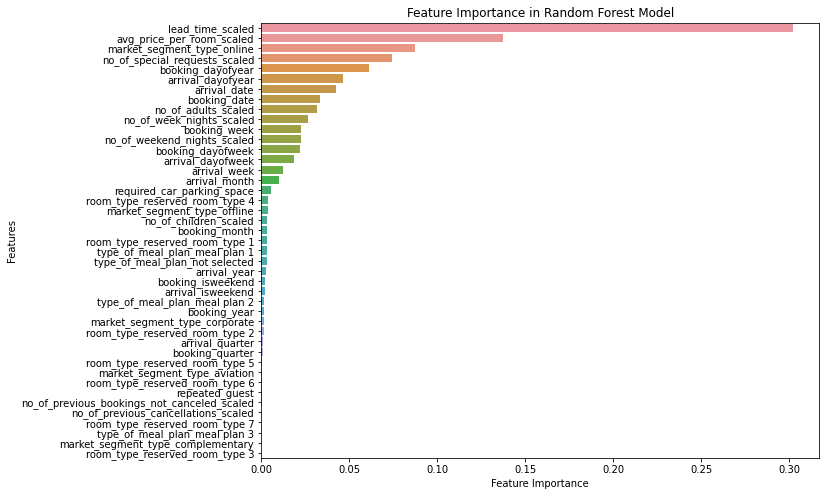

In [36]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Instantiate Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=150)

# Train the Random Forest Regressor model
rf.fit(X_train, y_train.values.ravel())

# Sort feature importances
sort = rf.feature_importances_.argsort()
features_sorted = np.array(X_train.columns.to_list())[sort]

# Create DataFrame to hold features and their importances
feature_importances = pd.DataFrame({'features': features_sorted, 'importance': rf.feature_importances_[sort]})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Plotting
sns.barplot(data=feature_importances, y="features", x="importance", order=feature_importances['features'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

Top 5 features with highest mutual importance and top 5 features with highest feauture importance are selected : <br>
1. lead_time_scaled <br>
2. avg_price_per_room_scaled <br>
3. market_segment_type_online <br>
4. no_of_special_requests_scaled <br>
5. booking_dayofyear <br>
6. arrival_dayofyear <br>
7. booking_dayofyear

## 1. Feature Selection for K-Nearest Neighbour 

In [75]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the training and testing data from CSV files
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
y_train = pd.read_csv("Data/y_train_undersampled_data.csv")
y_test = pd.read_csv("Data/y_test.csv")

Without any feature selection techniques:

In [38]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.values.ravel())

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.785958904109589


### Wrapper Method - Forward Selection
(takes abt 20 mins to run)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def forward_selection_with_metrics(X_train, y_train, X_test, y_test, model, total_features=None):
    """
    Perform forward selection for feature selection with a given machine learning model.

    Parameters:
    - X_train (array-like): Input features for training.
    - y_train (array-like): Target variable for training.
    - X_test (array-like): Input features for testing.
    - y_test (array-like): Target variable for testing.
    - model: Machine learning model object with fit and predict methods.
    - total_features (int): Total number of features to be selected. If None, select until no further improvement.

    Returns:
    - selected_features (list): List of selected feature indices.
    """
    selected_features = []
    best_accuracy = 0
    total_features = len(X_train.columns)
    # Convert DataFrame to NumPy array
    y_train_array = y_train.values.ravel()

    while len(selected_features) < total_features:
        best_feature = None
        for feature in X_train.columns:
            if feature not in selected_features:
                trial_features = selected_features + [feature]
                # Train the ML model with trial_features
                model.fit(X_train[trial_features], y_train_array)
                # Evaluate model performance using accuracy_score
                y_pred = model.predict(X_test[trial_features])
                accuracy = accuracy_score(y_test, y_pred)
                # Check if accuracy improved
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_feature = feature

        # If a new feature improves performance, add it to selected_features
        if best_feature is not None:
            selected_features.append(best_feature)
        else:
            # No further improvement can be made
            break

    print("Selected features:", selected_features)
    print("Best accuracy:", best_accuracy)

    return selected_features


In [23]:
# Instantiate the KNN classifier
knn_model = KNeighborsClassifier()

# Call the forward_selection_with_metrics function
selected_features = forward_selection_with_metrics(X_train, y_train, X_test, y_test, knn_model)

Selected features: ['no_of_nights_scaled', 'arrival_month_11', 'have_special_requests', 'avg_price_per_room_cat_200 to 300', 'market_segment_type_online', 'booking_month_7', 'avg_price_per_room_cat_0 to 50', 'arrival_month_7', 'booking_dayofweek_0', 'room_type_reserved_room_type 2', 'lead_time_cat_greater than 300', 'traveller_type_children_only', 'arrival_month_3', 'lead_time_cat_150 to 200', 'lead_time_cat_100 to 150']
Best accuracy: 0.8165362035225049


We see that there is an increase in the accuracy score after applying forward selection. 

### Forward selection using SequentialFeatureSelector from sklearn

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
import pandas as pd

# Load your datasets
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
y_train = pd.read_csv("Data/y_train_undersampled_data.csv")
y_test = pd.read_csv("Data/y_test.csv")

y_train_array = y_train.values.ravel()

# Initialize a KNN classifier
knn = KNeighborsClassifier()

# Initialize SequentialFeatureSelector
sfs = SequentialFeatureSelector(knn, n_features_to_select='auto', direction='forward', scoring='accuracy', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs.fit(X_train, y_train_array)

# Get the selected features
selected_features = X_train.columns[sfs.get_support()]

print("Selected Features:")
print(selected_features)

# Train the final model using the selected features
knn.fit(X_train[selected_features], y_train_array)

# Evaluate the model on the test data
y_pred = knn.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Selected Features:
Index(['traveller_type_children_only', 'stay_type_hour_room',
       'cancellation_type_all_cancelled', 'cancellation_type_all_successful',
       'cancellation_type_mixed', 'cancellation_type_no_booking',
       'lead_time_cat_100 to 150', 'lead_time_cat_150 to 200',
       'lead_time_cat_greater than 300', 'avg_price_per_room_cat_0 to 50',
       'avg_price_per_room_cat_200 to 300', 'avg_price_per_room_cat_50 to 100',
       'avg_price_per_room_cat_greater than 300', 'booking_month_7',
       'booking_month_8', 'booking_month_9', 'booking_month_10',
       'booking_month_11', 'arrival_season_spring', 'arrival_season_winter',
       'solo_traveller', 'have_special_requests',
       'no_of_previous_bookings_scaled', 'previous_cancellation_rate_scaled',
       'type_of_meal_plan_meal plan 2', 'type_of_meal_plan_meal plan 3',
       'room_type_reserved_room_type 1', 'room_type_reserved_room_type 2',
       'room_type_reserved_room_type 3', 'room_type_reserved_room_type

### Wrapper Method - Backward Elimination

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def backward_elimination_with_metrics(X_train, y_train, X_test, y_test, model, threshold=0, verbose=False):
    """
    Perform backward elimination for feature selection with a given machine learning model.

    Parameters:
    - X_train (array-like): Input features for training.
    - y_train (array-like): Target variable for training.
    - X_test (array-like): Input features for testing.
    - y_test (array-like): Target variable for testing.
    - model: Machine learning model object with fit and predict methods.
    - threshold (float): Minimum improvement threshold to continue removing features.
    - verbose (bool): Whether to print progress information.

    Returns:
    - selected_features (list): List of selected feature indices.
    """
    y_train_array = y_train.values.ravel()
    selected_features = list(X_train.columns)
    best_accuracy = accuracy_score(y_test, model.fit(X_train, y_train_array).predict(X_test))
    improvement = True

    while improvement:
        improvement = False
        for feature in selected_features:
            trial_features = selected_features.copy()
            trial_features.remove(feature)
            model.fit(X_train[trial_features], y_train_array)
            y_pred = model.predict(X_test[trial_features])
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy + threshold:
                selected_features.remove(feature)
                best_accuracy = accuracy
                improvement = True
                if verbose:
                    print(f"Removed feature {feature}, Accuracy: {accuracy}")
    
    print("Selected features:", selected_features)
    print("Best accuracy:", best_accuracy)
   
    return selected_features


In [43]:
# Instantiate the KNN classifier
knn_model = KNeighborsClassifier()

# Call the forward_selection_with_metrics function
selected_features = backward_elimination_with_metrics(X_train, y_train, X_test, y_test, knn_model)

Selected features: ['traveller_type_adults_only', 'traveller_type_mixed', 'stay_type_hour_room', 'cancellation_type_all_cancelled', 'cancellation_type_all_successful', 'cancellation_type_mixed', 'cancellation_type_no_booking', 'lead_time_cat_0 to 50', 'lead_time_cat_100 to 150', 'lead_time_cat_150 to 200', 'lead_time_cat_200 to 300', 'avg_price_per_room_cat_greater than 300', 'arrival_dayofweek_3', 'arrival_dayofweek_5', 'arrival_dayofweek_6', 'booking_month_2', 'booking_month_3', 'booking_month_4', 'booking_month_6', 'booking_month_8', 'booking_month_12', 'booking_dayofweek_0', 'booking_dayofweek_1', 'booking_dayofweek_2', 'booking_dayofweek_3', 'booking_dayofweek_5', 'arrival_season_spring', 'arrival_season_summer', 'have_special_requests', 'no_of_customers_scaled', 'no_of_nights_scaled', 'perc_weekday_nights_scaled', 'no_of_previous_bookings_scaled', 'previous_cancellation_rate_scaled', 'type_of_meal_plan_meal plan 1', 'type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected

### Backward elimination using SequentialFeatureSelector from sklearn

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
import pandas as pd

# Load your datasets
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
y_train = pd.read_csv("Data/y_train_undersampled_data.csv")
y_test = pd.read_csv("Data/y_test.csv")

y_train_array = y_train.values.ravel()

# Initialize a KNN classifier
knn = KNeighborsClassifier()

# Initialize SequentialFeatureSelector
sfs = SequentialFeatureSelector(knn, n_features_to_select='auto', direction='backward', scoring='accuracy', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs.fit(X_train, y_train_array)

# Get the selected features
selected_features = X_train.columns[sfs.get_support()]

print("Selected Features:")
print(selected_features)

# Train the final model using the selected features
knn.fit(X_train[selected_features], y_train_array)

# Evaluate the model on the test data
y_pred = knn.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Selected Features:
Index(['stay_type_mixed', 'stay_type_weekday_only', 'stay_type_weekend_only',
       'lead_time_cat_100 to 150', 'lead_time_cat_150 to 200',
       'lead_time_cat_50 to 100', 'avg_price_per_room_cat_0 to 50',
       'avg_price_per_room_cat_100 to 150', 'avg_price_per_room_cat_50 to 100',
       'arrival_dayofweek_2', 'arrival_dayofweek_3', 'arrival_dayofweek_4',
       'arrival_dayofweek_6', 'booking_month_1', 'booking_month_2',
       'booking_month_3', 'booking_month_4', 'booking_month_5',
       'booking_month_7', 'booking_month_11', 'booking_month_12',
       'booking_dayofweek_0', 'booking_dayofweek_1', 'booking_dayofweek_4',
       'booking_dayofweek_5', 'booking_dayofweek_6', 'arrival_season_spring',
       'solo_traveller', 'have_special_requests', 'booking_isweekend',
       'no_of_nights_scaled', 'type_of_meal_plan_meal plan 1',
       'type_of_meal_plan_not selected', 'room_type_reserved_room_type 2',
       'room_type_reserved_room_type 4', 'market_segmen

### Hyperparameter Tuning

Hyperparameter tuning for a KNN (K-Nearest Neighbors) model involves selecting the optimal value for the n_neighbors parameter, which determines the number of neighbors to consider when making predictions. Here, we use Grid Search with cross-validation. 

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

y_train_array = y_train.values.ravel()
parameter = {'n_neighbors': np.arange(2, 50, 1)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid=parameter, cv=5, verbose=1)
knn_cv.fit(X_train, y_train_array)
print(knn_cv.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'n_neighbors': 10}


Using the best parameter above to train the KNN model and calculate the evaluation metrics.

In [37]:
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train_array)
y_pred=knn.predict(X_test)
accuracy_score=accuracy_score(y_test, y_pred)*100
print("Accuracy for testing dataset after tuning : {:.2f}%".format(accuracy_score))

Accuracy for testing dataset after tuning : 80.04%


## 2. Feature Selection for Logistic Regression

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the training and testing data from CSV files
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
y_train = pd.read_csv("Data/y_train_undersampled_data.csv")
y_test = pd.read_csv("Data/y_test.csv")

Without any feature selection techniques:

In [33]:
# Train Logistic Regression model on the training data without feature selection
lr = LogisticRegression(max_iter=10000, random_state=47)
lr.fit(X_train, y_train.values.ravel())  # Use values.ravel() to flatten y_train

# Make predictions on the training and testing data
y_guess = lr.predict(X_train)
y_score = lr.predict(X_test)

# Calculate and print accuracy without feature selection and the number of original features
print("Accuracy No Feature Selection:", accuracy_score(y_test, y_score))

Accuracy No Feature Selection: 0.8142123287671232


### Wrapper Method - Forward Selection

In [32]:
# Instantiate the Logistic Regression classifier
log_reg_model = LogisticRegression()

# Call the forward_selection_with_metrics function
selected_features = forward_selection_with_metrics(X_train, y_train, X_test, y_test, log_reg_model)

Selected features: ['lead_time_cat_200 to 300', 'no_of_weekend_nights_scaled', 'cancellation_type_no_booking', 'avg_price_per_room_cat_0 to 50']
Best accuracy: 0.7961105675146771


We see that there is a decrease in the accuracy score after applying forward selection.

### Forward selection using SequentialFeatureSelector from sklearn

In [88]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
import pandas as pd

def forward_sequential_feature_selector(model, X_train, y_train, X_test, y_test):
    # Initialize SequentialFeatureSelector
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='accuracy', cv=5)

    # Fit the SequentialFeatureSelector to the training data
    sfs.fit(X_train, y_train)

    # Get the selected features
    selected_features = X_train.columns[sfs.get_support()]

    print("Selected Features:")
    print(selected_features)

    # Train the final model using the selected features
    model.fit(X_train[selected_features], y_train)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test[selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

# Load your datasets
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
y_train = pd.read_csv("Data/y_train_undersampled_data.csv").values.ravel()
y_test = pd.read_csv("Data/y_test.csv")

In [84]:
# Choose your model
model = LogisticRegression()

# Call the function to perform feature selection and evaluation
forward_sequential_feature_selector(model, X_train, y_train, X_test, y_test)

Selected Features:
Index(['traveller_type_adults_only', 'traveller_type_children_only',
       'traveller_type_mixed', 'stay_type_hour_room',
       'cancellation_type_all_cancelled', 'cancellation_type_all_successful',
       'cancellation_type_mixed', 'cancellation_type_no_booking',
       'lead_time_cat_100 to 150', 'lead_time_cat_50 to 100',
       'avg_price_per_room_cat_0 to 50',
       'avg_price_per_room_cat_greater than 300', 'arrival_dayofweek_0',
       'arrival_dayofweek_3', 'arrival_dayofweek_6', 'booking_month_1',
       'booking_month_5', 'booking_month_6', 'booking_month_7',
       'booking_month_8', 'booking_month_9', 'booking_month_11',
       'booking_dayofweek_0', 'booking_dayofweek_1', 'booking_dayofweek_3',
       'booking_dayofweek_4', 'arrival_season_summer', 'have_special_requests',
       'perc_adults_scaled', 'no_of_previous_bookings_scaled',
       'previous_cancellation_rate_scaled', 'type_of_meal_plan_meal plan 3',
       'room_type_reserved_room_type 2', 

### Wrapper Method - Backward Elimination

In [61]:
# Instantiate the Logistic Regression classifier
log_reg_model = LogisticRegression(max_iter=10000)

# Call the forward_selection_with_metrics function
selected_features = backward_elimination_with_metrics(X_train, y_train, X_test, y_test, log_reg_model)

Selected features: ['traveller_type_adults_only', 'traveller_type_children_only', 'traveller_type_mixed', 'stay_type_hour_room', 'stay_type_mixed', 'stay_type_weekend_only', 'cancellation_type_all_cancelled', 'cancellation_type_mixed', 'lead_time_cat_100 to 150', 'lead_time_cat_150 to 200', 'avg_price_per_room_cat_0 to 50', 'avg_price_per_room_cat_150 to 200', 'avg_price_per_room_cat_50 to 100', 'arrival_dayofweek_0', 'arrival_dayofweek_1', 'arrival_dayofweek_3', 'arrival_dayofweek_5', 'booking_month_1', 'booking_month_2', 'booking_month_5', 'booking_month_6', 'booking_month_8', 'booking_month_10', 'booking_month_11', 'booking_dayofweek_1', 'booking_dayofweek_3', 'booking_dayofweek_4', 'booking_dayofweek_5', 'booking_dayofweek_6', 'arrival_season_autumn', 'arrival_season_summer', 'arrival_season_winter', 'solo_traveller', 'have_special_requests', 'arrival_isweekend', 'booking_isweekend', 'num_of_customers_and_room_type_mismatch', 'no_of_customers_scaled', 'perc_adults_scaled', 'no_of_n

We see that there is an increase in the accuracy score after applying backward elimination.

### Backward elimination using SequentialFeatureSelector from sklearn

In [85]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
import pandas as pd

def backward_sequential_feature_selector(model, X_train, y_train, X_test, y_test):
    # Initialize SequentialFeatureSelector
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', scoring='accuracy', cv=5)

    # Fit the SequentialFeatureSelector to the training data
    sfs.fit(X_train, y_train)

    # Get the selected features
    selected_features = X_train.columns[sfs.get_support()]

    print("Selected Features:")
    print(selected_features)

    # Train the final model using the selected features
    model.fit(X_train[selected_features], y_train)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test[selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

# Load your datasets
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
y_train = pd.read_csv("Data/y_train_undersampled_data.csv").values.ravel()
y_test = pd.read_csv("Data/y_test.csv")

In [87]:
# Choose your model
model = LogisticRegression(max_iter = 1000)

# Call the function to perform feature selection and evaluation
backward_sequential_feature_selector(model, X_train, y_train, X_test, y_test)

Selected Features:
Index(['stay_type_mixed', 'stay_type_weekday_only',
       'cancellation_type_all_successful', 'lead_time_cat_0 to 50',
       'lead_time_cat_100 to 150', 'lead_time_cat_50 to 100',
       'avg_price_per_room_cat_0 to 50', 'avg_price_per_room_cat_200 to 300',
       'avg_price_per_room_cat_50 to 100', 'arrival_dayofweek_2',
       'arrival_dayofweek_3', 'arrival_dayofweek_4', 'booking_month_1',
       'booking_month_2', 'booking_month_3', 'booking_month_4',
       'booking_month_5', 'booking_month_6', 'booking_month_8',
       'booking_month_9', 'booking_month_10', 'booking_month_12',
       'booking_dayofweek_2', 'booking_dayofweek_4', 'booking_dayofweek_5',
       'arrival_season_summer', 'arrival_season_winter',
       'have_special_requests', 'booking_isweekend', 'no_of_customers_scaled',
       'perc_weekday_nights_scaled', 'type_of_meal_plan_meal plan 2',
       'type_of_meal_plan_not selected', 'room_type_reserved_room_type 1',
       'room_type_reserved_room_

### Wrapper Method - Recursive Feature Elimination with cross validation

In [80]:
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif
from sklearn.model_selection import StratifiedKFold 

def feature_selection_using_rfecv_on_accuracyscore(Model, X_train_data, Y_train_data):
    """
    Performs Recursive Feature Elimination with Cross-Validation (RFECV) to select features based on the Accuracy score.
    
    This function applies RFECV to a provided classifier model to determine the optimal number of features that
    maximizes the Accuracy score during cross-validation. It visualizes the model's performance as the number of features varies.

    Parameters:
    - Model : A scikit-learn-compatible classifier.
    - X_train_data : DataFrame, feature set for training.
    - Y_train_data : DataFrame/Series, target variable for training.
    
    Returns:
    - df_features : DataFrame containing the features, whether they are selected, and their ranking.
    """
    steps = 1
    cv = StratifiedKFold(5)
    # Initialize RFECV with the model and desired parameters
    rfecv = RFECV(estimator=Model, step=steps, cv=cv, scoring="accuracy", min_features_to_select=1, n_jobs=-1)
    rfecv.fit(X_train_data, Y_train_data.values.ravel())
    
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    
    # Visualize the optimal number of features
    plt.figure(figsize=(10, 6))
    plt.title("Model Performance vs. Number of Features")
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validation Score")
    plt.plot(range(1, (n_scores * steps) + 1, steps), rfecv.cv_results_["mean_test_score"], marker='o')
    plt.xticks(np.arange(0, (n_scores * steps) + 1, 5))
    plt.grid(True)
    plt.show()

    # Gather selected features into a DataFrame
    df_features = pd.DataFrame({
        "feature": X_train_data.columns,
        "selected": rfecv.support_,
        "ranking": rfecv.ranking_
    })

    print("Optimal number of features based on Accuracy Score: %d" % rfecv.n_features_)
    return df_features


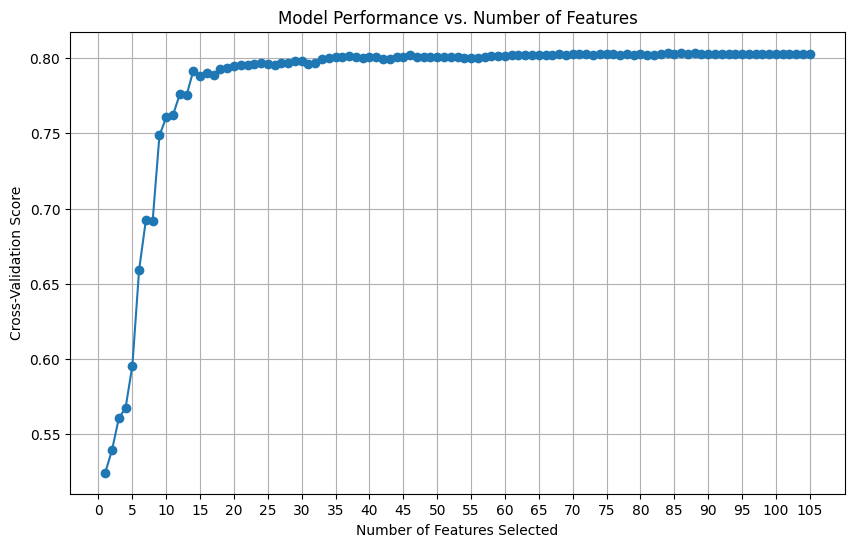

Optimal number of features based on Accuracy Score: 84


In [82]:
# Instantiate the Logistic Regression classifier
log_reg_model = LogisticRegression(max_iter=1000)

# Call the forward_selection_with_metrics function
selected_features = feature_selection_using_rfecv_on_accuracyscore(log_reg_model, X_train, y_train)

### Hyperparameter Tuning 
The main hyperparameters we may tune in logistic regression are: 
1. solver: the algorithm to use in the optimization problem
2. penalty: intends to reduce model generalization error, and is meant to disincentivize and regulate overfitting
3. regularization strength: works with the penalty to regulate overfitting (Smaller values specify stronger regularization and high value tells the model to give high weight to the training data.)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear', 'saga'],  # Optimization algorithm
}


# Create a logistic regression model
logistic_model = LogisticRegression(max_iter=1000)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train_array)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best model for prediction
best_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_model.score(X_test, y_test)